<a href="https://colab.research.google.com/github/im-hjk/dankook_dacon/blob/master/DACON_stacking%EC%9D%84%EC%9D%B4%EA%B2%A8%EB%B2%84%EB%A6%B0lgbm_optuna_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 라이브러리 import 및 설정

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install optuna

In [ ]:
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
import optuna.integration.lightgbm as lgb
import io
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
import warnings

In [ ]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

[03-pandas-eda.ipynb](https://github.com/kaggler-tv/dku-kaggle-class/blob/master/notebook/03-pandas-eda.ipynb)에서 생성한 `feature.csv` 피처파일 사용

In [ ]:
main_path = Path('/content/drive/My Drive/Colab Notebooks/dacon_dkdkdk')
data_dir = main_path / 'data/dacon-dku'
feature_dir = main_path / 'build/feature'
val_dir = main_path / 'build/val'
tst_dir = main_path / 'build/tst'
sub_dir = main_path / 'build/sub'

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [ ]:
algo_name = 'lgb_optuna'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [ ]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 29)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nDetect,class,airmass,n_obMde,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,u/g,u/r,u/i,u/z,g/i,g/z,r/i,r/z,i/z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,0.0,1.1898,0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,1.1439,1.2238,1.3164,1.3733,1.1508,1.2005,1.0757,1.1222,1.0433,-2.6257,-3.3488,2.0462,0.7232
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1.0,1.2533,0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,1.0704,1.1189,1.1344,1.1430,1.0598,1.0678,1.0139,1.0215,1.0076,-0.7683,-0.8698,0.2767,0.1016
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,0.0,1.0225,0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,1.0607,1.0805,1.0905,1.0936,1.0281,1.0310,1.0093,1.0121,1.0028,-0.3649,-0.3905,0.1440,0.0257
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,3,0.0,1.2054,1,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,1.2111,1.2690,1.2898,1.3069,1.0650,1.0791,1.0164,1.0299,1.0133,-1.2000,-1.4395,0.5321,0.2395
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,12,0.0,1.1940,1,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,1.1814,1.2842,1.3345,1.3598,1.1296,1.1511,1.0392,1.0589,1.0190,-2.2436,-2.5579,0.9871,0.3144


In [ ]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 28) (80000, 28)


## Hyperparameter Tuning

In [ ]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)

In [ ]:
params = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 3,
    "n_estimators": 3000,
    "subsample_freq": 1,
    "lambda_l1": 0.,
    "lambda_l2": 0.,
    "random_state": seed,
    "n_jobs": -1,
}

In [ ]:
dtrain = lgb.Dataset(X_trn, label=y_trn)
dval = lgb.Dataset(X_val, label=y_val)

model = lgb.train(params, dtrain, valid_sets=[dtrain, dval], 
                  verbose_eval=100, early_stopping_rounds=10)

prediction = np.argmax(model.predict(X_val, num_iteration=model.best_iteration), 
                       axis=1)
accuracy = accuracy_score(y_val, prediction)

params = model.params
print("Best params:", params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")
for key, value in params.items():
    print("    {}: {}".format(key, value))

[I 2020-10-09 08:04:34,104] A new study created in memory with name: no-name-0169f949-097b-4cad-9489-639683bde26b
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.150635	valid_1's multi_logloss: 0.163905
[200]	training's multi_logloss: 0.138147	valid_1's multi_logloss: 0.16072


feature_fraction, val_score: 0.159674:  14%|#4        | 1/7 [00:45<04:34, 45.72s/it]

Early stopping, best iteration is:
[289]	training's multi_logloss: 0.130603	valid_1's multi_logloss: 0.159674
Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.154048	valid_1's multi_logloss: 0.165613
[200]	training's multi_logloss: 0.140209	valid_1's multi_logloss: 0.160506
[300]	training's multi_logloss: 0.132047	valid_1's multi_logloss: 0.159359


feature_fraction, val_score: 0.159160:  29%|##8       | 2/7 [01:25<03:39, 43.85s/it]

Early stopping, best iteration is:
[336]	training's multi_logloss: 0.129622	valid_1's multi_logloss: 0.15916
Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.15106	valid_1's multi_logloss: 0.163866
[200]	training's multi_logloss: 0.138467	valid_1's multi_logloss: 0.160175


feature_fraction, val_score: 0.159160:  43%|####2     | 3/7 [02:11<02:57, 44.47s/it]

Early stopping, best iteration is:
[278]	training's multi_logloss: 0.131821	valid_1's multi_logloss: 0.159283
Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.15078	valid_1's multi_logloss: 0.163945
[200]	training's multi_logloss: 0.138098	valid_1's multi_logloss: 0.16045
[300]	training's multi_logloss: 0.129697	valid_1's multi_logloss: 0.159532


feature_fraction, val_score: 0.159160:  57%|#####7    | 4/7 [03:02<02:19, 46.48s/it]

Early stopping, best iteration is:
[346]	training's multi_logloss: 0.126377	valid_1's multi_logloss: 0.159264
Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.151586	valid_1's multi_logloss: 0.164353
[200]	training's multi_logloss: 0.138927	valid_1's multi_logloss: 0.160386
[300]	training's multi_logloss: 0.130618	valid_1's multi_logloss: 0.159228


feature_fraction, val_score: 0.158875:  57%|#####7    | 4/7 [03:49<02:19, 46.48s/it]

Early stopping, best iteration is:
[359]	training's multi_logloss: 0.126501	valid_1's multi_logloss: 0.158875


feature_fraction, val_score: 0.158875:  71%|#######1  | 5/7 [03:49<01:33, 46.69s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.152449	valid_1's multi_logloss: 0.164452
[200]	training's multi_logloss: 0.139542	valid_1's multi_logloss: 0.160285
[300]	training's multi_logloss: 0.131343	valid_1's multi_logloss: 0.159348


feature_fraction, val_score: 0.158875:  86%|########5 | 6/7 [04:30<00:44, 44.91s/it]

Early stopping, best iteration is:
[335]	training's multi_logloss: 0.128859	valid_1's multi_logloss: 0.159057
Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.156762	valid_1's multi_logloss: 0.167809
[200]	training's multi_logloss: 0.141257	valid_1's multi_logloss: 0.160545
[300]	training's multi_logloss: 0.133083	valid_1's multi_logloss: 0.159359
[400]	training's multi_logloss: 0.12644	valid_1's multi_logloss: 0.158752
Early stopping, best iteration is:
[406]	training's multi_logloss: 0.126069	valid_1's multi_logloss: 0.158718


num_leaves, val_score: 0.158718:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.130037	valid_1's multi_logloss: 0.161865
[200]	training's multi_logloss: 0.105674	valid_1's multi_logloss: 0.158305
Early stopping, best iteration is:
[198]	training's multi_logloss: 0.106063	valid_1's multi_logloss: 0.158278


num_leaves, val_score: 0.158278:   5%|5         | 1/20 [00:31<09:54, 31.29s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.120332	valid_1's multi_logloss: 0.161474
Early stopping, best iteration is:
[185]	training's multi_logloss: 0.0956357	valid_1's multi_logloss: 0.158607


num_leaves, val_score: 0.158278:  10%|#         | 2/20 [01:04<09:32, 31.79s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.166384	valid_1's multi_logloss: 0.173649
[200]	training's multi_logloss: 0.151842	valid_1's multi_logloss: 0.164594


num_leaves, val_score: 0.158278:  15%|#5        | 3/20 [01:25<08:06, 28.63s/it]

Early stopping, best iteration is:
[195]	training's multi_logloss: 0.152097	valid_1's multi_logloss: 0.16372
Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.141858	valid_1's multi_logloss: 0.16375
[200]	training's multi_logloss: 0.121841	valid_1's multi_logloss: 0.159023
Early stopping, best iteration is:
[267]	training's multi_logloss: 0.113196	valid_1's multi_logloss: 0.158647


num_leaves, val_score: 0.158278:  20%|##        | 4/20 [02:01<08:14, 30.93s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.113348	valid_1's multi_logloss: 0.161069
Early stopping, best iteration is:
[159]	training's multi_logloss: 0.0937651	valid_1's multi_logloss: 0.158679


num_leaves, val_score: 0.158278:  25%|##5       | 5/20 [02:33<07:45, 31.05s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.120332	valid_1's multi_logloss: 0.161474
Early stopping, best iteration is:
[185]	training's multi_logloss: 0.0956357	valid_1's multi_logloss: 0.158607


num_leaves, val_score: 0.158278:  30%|###       | 6/20 [03:06<07:22, 31.64s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.130439	valid_1's multi_logloss: 0.161949
[200]	training's multi_logloss: 0.106144	valid_1's multi_logloss: 0.15817
Early stopping, best iteration is:
[195]	training's multi_logloss: 0.106949	valid_1's multi_logloss: 0.158142


num_leaves, val_score: 0.158142:  35%|###5      | 7/20 [03:37<06:50, 31.57s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.13318	valid_1's multi_logloss: 0.162519
[200]	training's multi_logloss: 0.109872	valid_1's multi_logloss: 0.158645
Early stopping, best iteration is:
[209]	training's multi_logloss: 0.108356	valid_1's multi_logloss: 0.158582


num_leaves, val_score: 0.158142:  40%|####      | 8/20 [04:09<06:21, 31.78s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.140916	valid_1's multi_logloss: 0.163599
[200]	training's multi_logloss: 0.120449	valid_1's multi_logloss: 0.158839
Early stopping, best iteration is:
[225]	training's multi_logloss: 0.117083	valid_1's multi_logloss: 0.158724


num_leaves, val_score: 0.158142:  45%|####5     | 9/20 [04:41<05:48, 31.71s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.127619	valid_1's multi_logloss: 0.161906
[200]	training's multi_logloss: 0.102374	valid_1's multi_logloss: 0.15838
Early stopping, best iteration is:
[200]	training's multi_logloss: 0.102374	valid_1's multi_logloss: 0.15838


num_leaves, val_score: 0.158142:  50%|#####     | 10/20 [05:14<05:20, 32.01s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.153701	valid_1's multi_logloss: 0.16653
[200]	training's multi_logloss: 0.137463	valid_1's multi_logloss: 0.160136
[300]	training's multi_logloss: 0.128285	valid_1's multi_logloss: 0.159202
Early stopping, best iteration is:
[332]	training's multi_logloss: 0.125731	valid_1's multi_logloss: 0.159032


num_leaves, val_score: 0.158142:  55%|#####5    | 11/20 [05:52<05:05, 33.93s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.128526	valid_1's multi_logloss: 0.161981
[200]	training's multi_logloss: 0.103772	valid_1's multi_logloss: 0.158297
Early stopping, best iteration is:
[202]	training's multi_logloss: 0.103417	valid_1's multi_logloss: 0.158296


num_leaves, val_score: 0.158142:  60%|######    | 12/20 [06:25<04:28, 33.58s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.105475	valid_1's multi_logloss: 0.161121
Early stopping, best iteration is:
[154]	training's multi_logloss: 0.0862036	valid_1's multi_logloss: 0.159035


num_leaves, val_score: 0.158142:  65%|######5   | 13/20 [07:05<04:08, 35.50s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.119413	valid_1's multi_logloss: 0.161594
Early stopping, best iteration is:
[174]	training's multi_logloss: 0.0970844	valid_1's multi_logloss: 0.158827


num_leaves, val_score: 0.158142:  70%|#######   | 14/20 [07:37<03:26, 34.47s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.131599	valid_1's multi_logloss: 0.162316
[200]	training's multi_logloss: 0.107872	valid_1's multi_logloss: 0.158418
Early stopping, best iteration is:
[200]	training's multi_logloss: 0.107872	valid_1's multi_logloss: 0.158418


num_leaves, val_score: 0.158142:  75%|#######5  | 15/20 [08:08<02:47, 33.60s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.126708	valid_1's multi_logloss: 0.162025
[200]	training's multi_logloss: 0.101048	valid_1's multi_logloss: 0.158357
Early stopping, best iteration is:
[200]	training's multi_logloss: 0.101048	valid_1's multi_logloss: 0.158357


num_leaves, val_score: 0.158142:  80%|########  | 16/20 [08:42<02:13, 33.49s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.139112	valid_1's multi_logloss: 0.163471
[200]	training's multi_logloss: 0.118074	valid_1's multi_logloss: 0.159043
Early stopping, best iteration is:
[241]	training's multi_logloss: 0.112218	valid_1's multi_logloss: 0.158853


num_leaves, val_score: 0.158142:  85%|########5 | 17/20 [09:16<01:41, 33.77s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.126309	valid_1's multi_logloss: 0.161659
[200]	training's multi_logloss: 0.100574	valid_1's multi_logloss: 0.158268
Early stopping, best iteration is:
[194]	training's multi_logloss: 0.101732	valid_1's multi_logloss: 0.158267


num_leaves, val_score: 0.158142:  90%|######### | 18/20 [09:49<01:06, 33.45s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.12463	valid_1's multi_logloss: 0.161911
Early stopping, best iteration is:
[160]	training's multi_logloss: 0.106963	valid_1's multi_logloss: 0.158864


num_leaves, val_score: 0.158142:  95%|#########5| 19/20 [10:17<00:31, 31.94s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.113549	valid_1's multi_logloss: 0.161016
Early stopping, best iteration is:
[173]	training's multi_logloss: 0.0904945	valid_1's multi_logloss: 0.158279


bagging, val_score: 0.158142:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.132101	valid_1's multi_logloss: 0.163018
[200]	training's multi_logloss: 0.106378	valid_1's multi_logloss: 0.159647
Early stopping, best iteration is:
[196]	training's multi_logloss: 0.107181	valid_1's multi_logloss: 0.159581


bagging, val_score: 0.158142:  10%|#         | 1/10 [00:35<05:15, 35.01s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.130645	valid_1's multi_logloss: 0.162136
[200]	training's multi_logloss: 0.105471	valid_1's multi_logloss: 0.158344
Early stopping, best iteration is:
[208]	training's multi_logloss: 0.10397	valid_1's multi_logloss: 0.158304


bagging, val_score: 0.158142:  20%|##        | 2/10 [01:10<04:40, 35.04s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.130405	valid_1's multi_logloss: 0.162113
[200]	training's multi_logloss: 0.105902	valid_1's multi_logloss: 0.158209
Early stopping, best iteration is:
[197]	training's multi_logloss: 0.106396	valid_1's multi_logloss: 0.15818


bagging, val_score: 0.158142:  30%|###       | 3/10 [01:43<04:01, 34.48s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.130305	valid_1's multi_logloss: 0.16237
[200]	training's multi_logloss: 0.105969	valid_1's multi_logloss: 0.158735
Early stopping, best iteration is:
[207]	training's multi_logloss: 0.104699	valid_1's multi_logloss: 0.158732


bagging, val_score: 0.158142:  40%|####      | 4/10 [02:17<03:26, 34.41s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.130894	valid_1's multi_logloss: 0.162452
[200]	training's multi_logloss: 0.105381	valid_1's multi_logloss: 0.158627
Early stopping, best iteration is:
[191]	training's multi_logloss: 0.107142	valid_1's multi_logloss: 0.158595


bagging, val_score: 0.158142:  50%|#####     | 5/10 [02:56<02:58, 35.63s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.132828	valid_1's multi_logloss: 0.163238
Early stopping, best iteration is:
[178]	training's multi_logloss: 0.111253	valid_1's multi_logloss: 0.160163


bagging, val_score: 0.158142:  60%|######    | 6/10 [03:27<02:17, 34.43s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.131176	valid_1's multi_logloss: 0.162742
[200]	training's multi_logloss: 0.105263	valid_1's multi_logloss: 0.159274
Early stopping, best iteration is:
[195]	training's multi_logloss: 0.106233	valid_1's multi_logloss: 0.159214


bagging, val_score: 0.158142:  70%|#######   | 7/10 [04:05<01:46, 35.37s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.130257	valid_1's multi_logloss: 0.162441
Early stopping, best iteration is:
[186]	training's multi_logloss: 0.108188	valid_1's multi_logloss: 0.158493


bagging, val_score: 0.158142:  80%|########  | 8/10 [04:44<01:12, 36.48s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.130814	valid_1's multi_logloss: 0.162149
Early stopping, best iteration is:
[183]	training's multi_logloss: 0.10857	valid_1's multi_logloss: 0.158469


bagging, val_score: 0.158142:  90%|######### | 9/10 [05:15<00:34, 34.87s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.131251	valid_1's multi_logloss: 0.162726
Early stopping, best iteration is:
[185]	training's multi_logloss: 0.108245	valid_1's multi_logloss: 0.158845


feature_fraction_stage2, val_score: 0.158142:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.130439	valid_1's multi_logloss: 0.161949
[200]	training's multi_logloss: 0.106144	valid_1's multi_logloss: 0.15817
Early stopping, best iteration is:
[195]	training's multi_logloss: 0.106949	valid_1's multi_logloss: 0.158142


feature_fraction_stage2, val_score: 0.158142:  33%|###3      | 1/3 [00:37<01:14, 37.46s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.12873	valid_1's multi_logloss: 0.161168
[200]	training's multi_logloss: 0.105484	valid_1's multi_logloss: 0.158384
Early stopping, best iteration is:
[191]	training's multi_logloss: 0.107039	valid_1's multi_logloss: 0.158371


feature_fraction_stage2, val_score: 0.158142:  67%|######6   | 2/3 [01:08<00:35, 35.63s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.127827	valid_1's multi_logloss: 0.160985
Early stopping, best iteration is:
[159]	training's multi_logloss: 0.112415	valid_1's multi_logloss: 0.1586


regularization_factors, val_score: 0.158142:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.130423	valid_1's multi_logloss: 0.16219
[200]	training's multi_logloss: 0.106186	valid_1's multi_logloss: 0.158585
Early stopping, best iteration is:
[190]	training's multi_logloss: 0.107894	valid_1's multi_logloss: 0.158547


regularization_factors, val_score: 0.158142:   5%|5         | 1/20 [00:30<09:44, 30.75s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.135759	valid_1's multi_logloss: 0.16251
[200]	training's multi_logloss: 0.114737	valid_1's multi_logloss: 0.158161
Early stopping, best iteration is:
[256]	training's multi_logloss: 0.10712	valid_1's multi_logloss: 0.157949


regularization_factors, val_score: 0.157949:  10%|#         | 2/20 [01:12<10:15, 34.20s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.136266	valid_1's multi_logloss: 0.162311
[200]	training's multi_logloss: 0.115561	valid_1's multi_logloss: 0.157963
Early stopping, best iteration is:
[239]	training's multi_logloss: 0.110055	valid_1's multi_logloss: 0.157746


regularization_factors, val_score: 0.157746:  15%|#5        | 3/20 [01:52<10:08, 35.81s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.135242	valid_1's multi_logloss: 0.162313
[200]	training's multi_logloss: 0.11381	valid_1's multi_logloss: 0.158189
Early stopping, best iteration is:
[206]	training's multi_logloss: 0.112934	valid_1's multi_logloss: 0.158144


regularization_factors, val_score: 0.157746:  20%|##        | 4/20 [02:27<09:26, 35.40s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.137084	valid_1's multi_logloss: 0.162645
[200]	training's multi_logloss: 0.116978	valid_1's multi_logloss: 0.158095
Early stopping, best iteration is:
[227]	training's multi_logloss: 0.113096	valid_1's multi_logloss: 0.157923


regularization_factors, val_score: 0.157746:  25%|##5       | 5/20 [03:05<09:03, 36.21s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.13624	valid_1's multi_logloss: 0.162496
[200]	training's multi_logloss: 0.115276	valid_1's multi_logloss: 0.157973
Early stopping, best iteration is:
[226]	training's multi_logloss: 0.111865	valid_1's multi_logloss: 0.15788


regularization_factors, val_score: 0.157746:  30%|###       | 6/20 [03:42<08:32, 36.60s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.136974	valid_1's multi_logloss: 0.162608
[200]	training's multi_logloss: 0.116661	valid_1's multi_logloss: 0.158113
Early stopping, best iteration is:
[222]	training's multi_logloss: 0.113478	valid_1's multi_logloss: 0.158032


regularization_factors, val_score: 0.157746:  35%|###5      | 7/20 [04:19<07:57, 36.77s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.13625	valid_1's multi_logloss: 0.16242
[200]	training's multi_logloss: 0.115169	valid_1's multi_logloss: 0.157896
Early stopping, best iteration is:
[236]	training's multi_logloss: 0.1101	valid_1's multi_logloss: 0.157781


regularization_factors, val_score: 0.157746:  40%|####      | 8/20 [04:58<07:29, 37.44s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.135754	valid_1's multi_logloss: 0.162288
[200]	training's multi_logloss: 0.114789	valid_1's multi_logloss: 0.15802
Early stopping, best iteration is:
[208]	training's multi_logloss: 0.113684	valid_1's multi_logloss: 0.157989


regularization_factors, val_score: 0.157746:  45%|####5     | 9/20 [05:33<06:42, 36.57s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.136925	valid_1's multi_logloss: 0.162653
[200]	training's multi_logloss: 0.116464	valid_1's multi_logloss: 0.158039
Early stopping, best iteration is:
[241]	training's multi_logloss: 0.110911	valid_1's multi_logloss: 0.157898


regularization_factors, val_score: 0.157746:  50%|#####     | 10/20 [06:13<06:16, 37.68s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.136747	valid_1's multi_logloss: 0.162669
[200]	training's multi_logloss: 0.116292	valid_1's multi_logloss: 0.158301
Early stopping, best iteration is:
[235]	training's multi_logloss: 0.111415	valid_1's multi_logloss: 0.158191


regularization_factors, val_score: 0.157746:  55%|#####5    | 11/20 [06:52<05:43, 38.15s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.136863	valid_1's multi_logloss: 0.1626
[200]	training's multi_logloss: 0.116187	valid_1's multi_logloss: 0.158114
Early stopping, best iteration is:
[224]	training's multi_logloss: 0.112947	valid_1's multi_logloss: 0.157999


regularization_factors, val_score: 0.157746:  60%|######    | 12/20 [07:30<05:04, 38.04s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.137076	valid_1's multi_logloss: 0.162636
[200]	training's multi_logloss: 0.116763	valid_1's multi_logloss: 0.158124
Early stopping, best iteration is:
[240]	training's multi_logloss: 0.111468	valid_1's multi_logloss: 0.157952


regularization_factors, val_score: 0.157746:  65%|######5   | 13/20 [08:10<04:30, 38.59s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.13085	valid_1's multi_logloss: 0.162503
[200]	training's multi_logloss: 0.106697	valid_1's multi_logloss: 0.158505
Early stopping, best iteration is:
[195]	training's multi_logloss: 0.107564	valid_1's multi_logloss: 0.158476


regularization_factors, val_score: 0.157746:  70%|#######   | 14/20 [08:48<03:50, 38.36s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.130846	valid_1's multi_logloss: 0.162293
[200]	training's multi_logloss: 0.106786	valid_1's multi_logloss: 0.158349
Early stopping, best iteration is:
[200]	training's multi_logloss: 0.106786	valid_1's multi_logloss: 0.158349


regularization_factors, val_score: 0.157746:  75%|#######5  | 15/20 [09:20<03:02, 36.57s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.131067	valid_1's multi_logloss: 0.162326
[200]	training's multi_logloss: 0.107066	valid_1's multi_logloss: 0.158705
Early stopping, best iteration is:
[208]	training's multi_logloss: 0.105729	valid_1's multi_logloss: 0.158683


regularization_factors, val_score: 0.157746:  80%|########  | 16/20 [09:54<02:22, 35.68s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.131731	valid_1's multi_logloss: 0.162073
[200]	training's multi_logloss: 0.108275	valid_1's multi_logloss: 0.158244
Early stopping, best iteration is:
[215]	training's multi_logloss: 0.105879	valid_1's multi_logloss: 0.15821


regularization_factors, val_score: 0.157746:  85%|########5 | 17/20 [10:29<01:46, 35.44s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.141281	valid_1's multi_logloss: 0.163416
[200]	training's multi_logloss: 0.123028	valid_1's multi_logloss: 0.158597
Early stopping, best iteration is:
[253]	training's multi_logloss: 0.116961	valid_1's multi_logloss: 0.158329


regularization_factors, val_score: 0.157746:  90%|######### | 18/20 [11:10<01:14, 37.24s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.130302	valid_1's multi_logloss: 0.162148
[200]	training's multi_logloss: 0.106161	valid_1's multi_logloss: 0.158158
Early stopping, best iteration is:
[200]	training's multi_logloss: 0.106161	valid_1's multi_logloss: 0.158158


regularization_factors, val_score: 0.157746:  95%|#########5| 19/20 [11:42<00:35, 35.71s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.132644	valid_1's multi_logloss: 0.162212
[200]	training's multi_logloss: 0.109781	valid_1's multi_logloss: 0.158277
Early stopping, best iteration is:
[198]	training's multi_logloss: 0.110123	valid_1's multi_logloss: 0.158247


min_data_in_leaf, val_score: 0.157746:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.136028	valid_1's multi_logloss: 0.162345
[200]	training's multi_logloss: 0.115534	valid_1's multi_logloss: 0.158008
Early stopping, best iteration is:
[211]	training's multi_logloss: 0.114013	valid_1's multi_logloss: 0.157949


min_data_in_leaf, val_score: 0.157746:  20%|##        | 1/5 [00:35<02:23, 35.87s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.136302	valid_1's multi_logloss: 0.162482
[200]	training's multi_logloss: 0.115721	valid_1's multi_logloss: 0.158311
Early stopping, best iteration is:
[225]	training's multi_logloss: 0.112235	valid_1's multi_logloss: 0.158227


min_data_in_leaf, val_score: 0.157746:  40%|####      | 2/5 [01:13<01:49, 36.36s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.13617	valid_1's multi_logloss: 0.162458
[200]	training's multi_logloss: 0.115619	valid_1's multi_logloss: 0.158072
Early stopping, best iteration is:
[202]	training's multi_logloss: 0.115332	valid_1's multi_logloss: 0.158031


min_data_in_leaf, val_score: 0.157746:  60%|######    | 3/5 [01:47<01:11, 35.67s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.137242	valid_1's multi_logloss: 0.162549
[200]	training's multi_logloss: 0.116483	valid_1's multi_logloss: 0.158065
Early stopping, best iteration is:
[252]	training's multi_logloss: 0.109314	valid_1's multi_logloss: 0.157822


min_data_in_leaf, val_score: 0.157746:  80%|########  | 4/5 [02:29<00:37, 37.65s/it]

Training until validation scores don't improve for 10 rounds.
[100]	training's multi_logloss: 0.136739	valid_1's multi_logloss: 0.162716
[200]	training's multi_logloss: 0.115821	valid_1's multi_logloss: 0.158294
Early stopping, best iteration is:
[219]	training's multi_logloss: 0.113112	valid_1's multi_logloss: 0.1582


min_data_in_leaf, val_score: 0.157746: 100%|##########| 5/5 [03:06<00:00, 37.22s/it]


Best params: {'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': 3, 'lambda_l1': 1.6189202148025895e-08, 'lambda_l2': 7.410688264307839, 'random_state': 42, 'n_jobs': -1, 'feature_pre_filter': False, 'bagging_freq': 1, 'num_leaves': 119, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'min_child_samples': 20}
  Accuracy = 0.93365625
  Params: 
    objective: multiclass
    metric: multi_logloss
    num_class: 3
    lambda_l1: 1.6189202148025895e-08
    lambda_l2: 7.410688264307839
    random_state: 42
    n_jobs: -1
    feature_pre_filter: False
    bagging_freq: 1
    num_leaves: 119
    feature_fraction: 0.4
    bagging_fraction: 1.0
    min_child_samples: 20


## Stratified K-Fold Cross Validation

In [ ]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

## LightGBM 모델 학습

In [ ]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = LGBMClassifier(**params)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10
            )
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.879971	valid_0's multi_logloss: 0.879971
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's multi_logloss: 0.79408	valid_0's multi_logloss: 0.79408
[3]	valid_0's multi_logloss: 0.720777	valid_0's multi_logloss: 0.720777
[4]	valid_0's multi_logloss: 0.661654	valid_0's multi_logloss: 0.661654
[5]	valid_0's multi_logloss: 0.607757	valid_0's multi_logloss: 0.607757
[6]	valid_0's multi_logloss: 0.5641	valid_0's multi_logloss: 0.5641
[7]	valid_0's multi_logloss: 0.523582	valid_0's multi_logloss: 0.523582
[8]	valid_0's multi_logloss: 0.489913	valid_0's multi_logloss: 0.489913
[9]	valid_0's multi_logloss: 0.456677	valid_0's multi_logloss: 0.456677
[10]	valid_0's multi_logloss: 0.430618	valid_0's multi_logloss: 0.430618
[11]	valid_0's multi_logloss: 0.40615	valid_0's multi_logloss: 0.40615
[12]	valid_0's multi_logloss: 0.381702	valid_0's multi_logloss: 0.381702
[13]	valid_0's multi_logloss: 0.363139	valid_0's multi

In [ ]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.4184%


In [ ]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [ ]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화

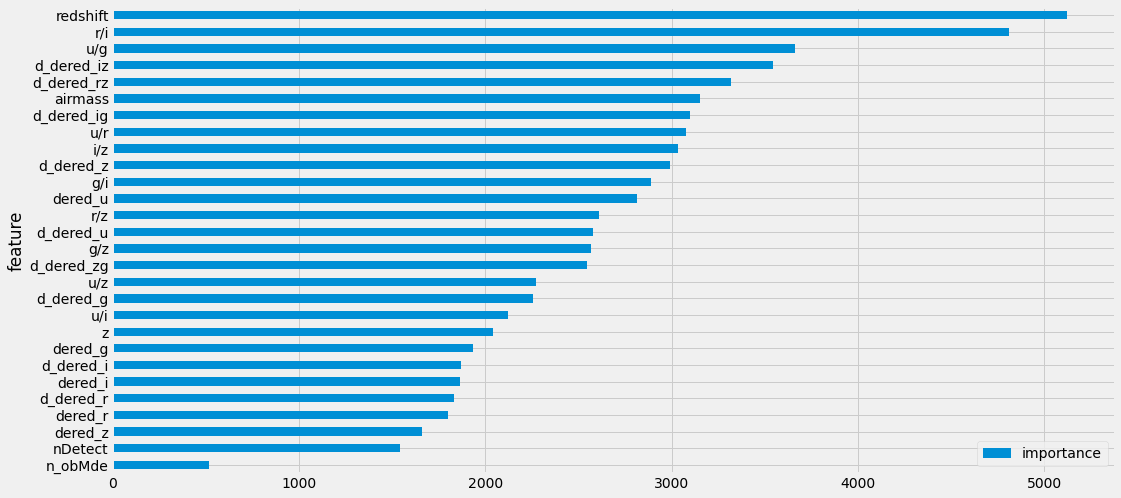

In [ ]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [ ]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [ ]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [ ]:
sub[target_col].value_counts()

2    40740
0    29978
1     9282
Name: class, dtype: int64

In [ ]:
sub.to_csv(sub_file)